In [196]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import xgboost as xgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [197]:
# load data
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
data = {
    'tra': pd.read_csv('{}/air_visit_data.csv'.format(data_dir)),
    'tes': pd.read_csv('{}/sample_submission.csv'.format(data_dir)),
    'as': pd.read_csv('{}/air_store_info.csv'.format(data_dir)),
    'hs': pd.read_csv('{}/hpg_store_info.csv'.format(data_dir)),
    'ar': pd.read_csv('{}/air_reserve.csv'.format(data_dir)),
    'hr': pd.read_csv('{}/hpg_reserve.csv'.format(data_dir)),
    'id': pd.read_csv('{}/store_id_relation.csv'.format(data_dir)),
    'hol': pd.read_csv('{}/date_info.csv'.format(data_dir))
}

data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))

# drop_vars = ['min_visits_in_hpb_loc',
#  'min_visits_in_area_name',
#  'holiday_flg',
#  'stores_in_hpb_loc',
#  'dur_time_holiday_flg',
#  'std_visits_in_hpb_loc',
#  'mean_visits_in_hpb_loc',
#  'stores_in_hpb_area_name',
#  'min_visits_in_hpb_area_name',
#  'min_visits_in_air_loc',
#  'dur_prog_holiday_flg',
#  'max_visits_in_hpb_area_name',
#  'max_visits_in_hpb_loc',
#  'std_visits_in_hpb_area_name',
#  'mean_visits_in_hpb_area_name',
#  'std_visits_in_area_name',
#  'visit_date_year',
#  'stores_in_air_loc',
#  'max_visits_in_air_loc',
#  'dur_holiday_flg',
#  'hpb_area_name',
#  'mean_visits_in_area_name']

feas = utils.data2fea(trn, data_dir, drop_vars=[])

                       visit_date          air_store_id  visitors  \
air_store_id                                                        
air_00a91d42b08b08d9 0 2016-07-01  air_00a91d42b08b08d9        35   
                     1 2016-07-02  air_00a91d42b08b08d9         9   
                     2 2016-07-04  air_00a91d42b08b08d9        20   
                     3 2016-07-05  air_00a91d42b08b08d9        25   
                     4 2016-07-06  air_00a91d42b08b08d9        29   

                        rolling_60d_max  rolling_60d_min  rolling_60d_median  \
air_store_id                                                                   
air_00a91d42b08b08d9 0              NaN              NaN                 NaN   
                     1             35.0             35.0                35.0   
                     2             35.0              9.0                22.0   
                     3             35.0              9.0                20.0   
                     4             3

1. 历史同期
2. 

In [200]:
feas['tidy_data']['rolling_60d_median'].head(100)

189299     NaN
200675     NaN
213541     NaN
161915     NaN
142213     NaN
42129      NaN
65991      NaN
121616     NaN
204401     NaN
184317     NaN
202599     NaN
196347     NaN
139665     NaN
118975     NaN
43841      NaN
5991       NaN
54021      NaN
56814      NaN
175206     NaN
66421      NaN
83562      NaN
180078     NaN
191031     NaN
45645      NaN
205401     NaN
215988     NaN
123951     NaN
104602     NaN
51542      NaN
131958     NaN
          ... 
153404     2.0
9208       NaN
205402    21.0
31280      NaN
121617    17.0
42130     11.0
204402    34.0
210724     NaN
151724     NaN
51543      6.0
43842     42.0
139666    12.0
66422     21.0
29556     56.0
123115     NaN
27515      NaN
123952    33.0
181423     NaN
231989     NaN
58944      NaN
148638    31.0
219542     NaN
178693     NaN
161916    55.0
215989    16.0
246430     4.0
101250     NaN
59702      NaN
6465       8.0
145631     NaN
Name: rolling_60d_median, Length: 100, dtype: float64

In [10]:
test_df.air_store_id.describe()

count                    32019
unique                     821
top       air_931a8a4321b6e7d1
freq                        39
Name: air_store_id, dtype: object

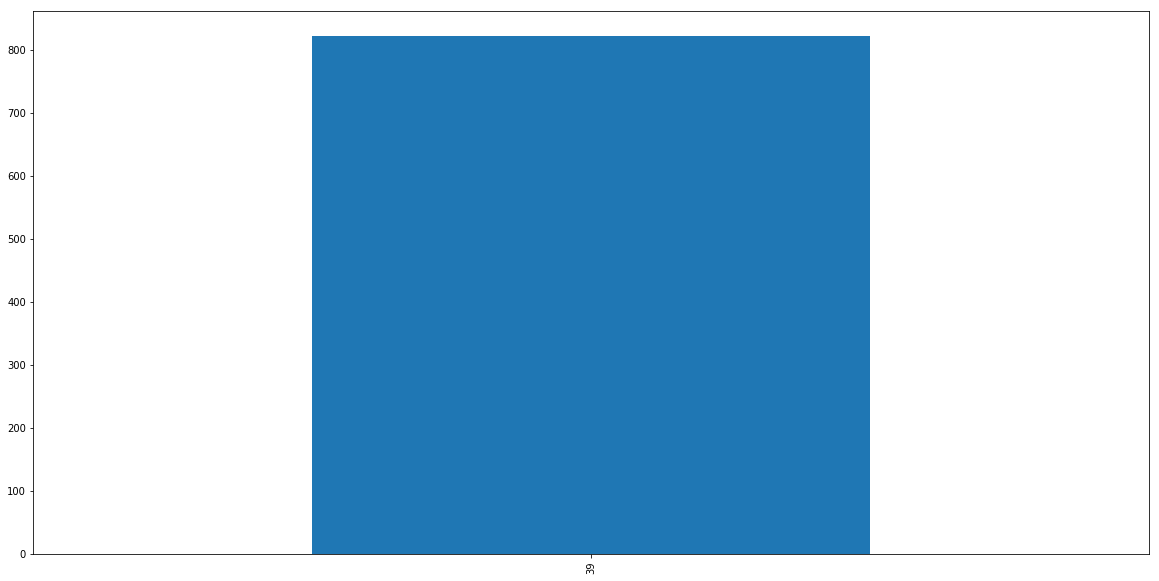

In [68]:
s = test_df.groupby("air_store_id").visit_date.nunique()
pd.value_counts(s).plot(kind="bar")

In [187]:
trn = data['tra']
trn.visit_date = pd.to_datetime(trn.visit_date)
trn = trn.groupby('air_store_id').apply(func)

In [155]:
def func(a_store_df, period='60d'):
    a_store_df = a_store_df.set_index('visit_date')
    rolling_max = a_store_df["visitors"].rolling(period).max().shift(1)
    rolling_min = a_store_df["visitors"].rolling(period).min().shift(1)
    rolling_median = a_store_df["visitors"].rolling(period).median().shift(1)
    rolling_std = a_store_df["visitors"].rolling(period).std().shift(1)
    a_store_df = a_store_df.reset_index()
    for stat, var_name in zip([rolling_max, rolling_min, rolling_median, rolling_std], 
                ["rolling_{}_max".format(period), "rolling_{}_min".format(period), 
                 "rolling_{}_median".format(period), "rolling_{}_std".format(period)]):
        stat = pd.DataFrame(stat).reset_index()
        stat = stat.rename(
            {
                'visitors': var_name,
            }, axis="columns"
        )
        a_store_df = pd.merge(a_store_df, stat, on='visit_date', how='left')
    return a_store_df
trn.index = trn.index.droplevel()

In [188]:
tra = data['tra']

In [189]:
tra.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [190]:
trn = trn.drop('visitors', axis='columns', errors='ignore')
tra = pd.merge(tra, trn, how='left', on=['air_store_id', 'visit_date'])

In [191]:
tra.head()

,air_store_id,visit_date,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,25.0,25.0,25.0,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,32.0,25.0,28.5,4.949747
3,air_ba937bf13d40fb24,2016-01-16,22,32.0,25.0,29.0,3.511885
4,air_ba937bf13d40fb24,2016-01-18,6,32.0,22.0,27.0,4.396969


In [186]:
trn

,air_store_id,visit_date
0,air_ba937bf13d40fb24,2016-01-13
1,air_ba937bf13d40fb24,2016-01-14
2,air_ba937bf13d40fb24,2016-01-15
3,air_ba937bf13d40fb24,2016-01-16
4,air_ba937bf13d40fb24,2016-01-18
5,air_ba937bf13d40fb24,2016-01-19
6,air_ba937bf13d40fb24,2016-01-20
7,air_ba937bf13d40fb24,2016-01-21
8,air_ba937bf13d40fb24,2016-01-22
9,air_ba937bf13d40fb24,2016-01-23


In [145]:
print(str_date_hol.dur_holiday_flg.unique())
print(str_date_hol.dur_time_holiday_flg.unique())
print(str_date_hol.dur_prog_holiday_flg.unique())

[3 0 1 2 6]
[1 2 3 0 4 5 6]
[ 0.33333333  0.66666667  1.          0.          0.5         0.16666667
  0.83333333]


In [122]:
a_store_df

,visit_date,air_store_id,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std
0,2016-07-01,air_fff68b929994bfbd,3,NaN,NaN,NaN,NaN
1,2016-07-02,air_fff68b929994bfbd,3,3.0,3.0,3.0,NaN
2,2016-07-05,air_fff68b929994bfbd,7,3.0,3.0,3.0,0.000000
3,2016-07-06,air_fff68b929994bfbd,6,7.0,3.0,3.0,2.309401
4,2016-07-07,air_fff68b929994bfbd,1,7.0,3.0,4.5,2.061553
5,2016-07-08,air_fff68b929994bfbd,5,7.0,1.0,3.0,2.449490
6,2016-07-09,air_fff68b929994bfbd,6,7.0,1.0,4.0,2.228602
7,2016-07-11,air_fff68b929994bfbd,5,7.0,1.0,5.0,2.149197
8,2016-07-12,air_fff68b929994bfbd,7,7.0,1.0,5.0,2.000000
9,2016-07-13,air_fff68b929994bfbd,2,7.0,1.0,5.0,2.048034


In [103]:
agg

,visit_date,visitors
0,2016-07-01,NaN
1,2016-07-02,NaN
2,2016-07-05,0.000000
3,2016-07-06,2.309401
4,2016-07-07,2.061553
5,2016-07-08,2.449490
6,2016-07-09,2.228602
7,2016-07-11,2.149197
8,2016-07-12,2.000000
9,2016-07-13,2.048034
